# Country Index Factor Analysis: Mean Reversion Test

Testing the hypothesis: "The correlation of the yearly return of the previous year to the yearly return of the following year is negative, i.e. if an index was the best performer last year, it tends to underperform this year."

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Prepare Data

In [15]:
# Load data
df = pd.read_csv('data/tradingview/country_indexes/spx_n_others_monthly.csv', index_col='time', parse_dates=True)

# Filter from 2000 onwards
df = df[df.index >= '2000-01-01']

print(f"Data shape: {df.shape}")
print(f"\nDate range: {df.index.min()} to {df.index.max()}")
print(f"\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

Data shape: (311, 10)

Date range: 2000-01-03 00:00:00 to 2025-11-03 00:00:00

Column names:
  - close
  - SET · SET: close
  - VN30 · HOSE: close
  - NIFTY · NSE: close
  - HSI · HSI: close
  - 000300 · SSE: close
  - KOSPI · KRX: close
  - TOPIX · TSE: close
  - SXXP · TVC: close
  - NDQ · TVC: close


In [16]:
# Check data availability
print("Data completeness (% non-null):")
print((df.notna().sum() / len(df) * 100).round(1))

Data completeness (% non-null):
close                  100.0
SET · SET: close       100.0
VN30 · HOSE: close      51.1
NIFTY · NSE: close     100.0
HSI · HSI: close       100.0
000300 · SSE: close     78.5
KOSPI · KRX: close     100.0
TOPIX · TSE: close     100.0
SXXP · TVC: close       92.6
NDQ · TVC: close       100.0
dtype: float64


In [17]:
# Rename 'close' column to 'SPX' for clarity
df = df.rename(columns={'close': 'SPX'})

# Clean up column names (remove exchange suffixes for readability)
column_mapping = {}
for col in df.columns:
    if ':' in col:
        # Extract the index name before the colon
        clean_name = col.split(':')[0].strip()
        column_mapping[col] = clean_name

df = df.rename(columns=column_mapping)
print("\nCleaned column names:")
print(df.columns.tolist())


Cleaned column names:
['SPX', 'SET · SET', 'VN30 · HOSE', 'NIFTY · NSE', 'HSI · HSI', '000300 · SSE', 'KOSPI · KRX', 'TOPIX · TSE', 'SXXP · TVC', 'NDQ · TVC']


## 2. Calculate Yearly Returns

In [18]:
# Get year-end prices (December of each year)
df['year'] = df.index.year

# For each year, get the last available price in December
yearly_prices = df.groupby('year').last()

# Calculate yearly returns (percentage change)
yearly_returns = yearly_prices.pct_change() * 100

# Drop the 'year' column if it exists
if 'year' in yearly_returns.columns:
    yearly_returns = yearly_returns.drop('year', axis=1)

print(f"Yearly returns shape: {yearly_returns.shape}")
print(f"Years covered: {yearly_returns.index.min()} to {yearly_returns.index.max()}")
print("\nFirst few years of returns:")
yearly_returns.head()

Yearly returns shape: (26, 10)
Years covered: 2000 to 2025

First few years of returns:


,SPX,SET · SET,VN30 · HOSE,NIFTY · NSE,HSI · HSI,000300 · SSE,KOSPI · KRX,TOPIX · TSE,SXXP · TVC,NDQ · TVC
year,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,-13.051117,12.875668,NaN,-16.184559,-24.503180,NaN,37.480682,-19.594600,NaN,-32.653635
2002,-23.371307,17.321046,NaN,3.252915,-18.212775,NaN,-9.535825,-18.296938,-32.467444,-37.582196
2003,26.380396,114.382282,NaN,71.902149,34.916948,NaN,29.186524,23.764058,13.249722,49.124317
2004,8.993453,-12.578674,NaN,10.679612,13.153149,NaN,10.510535,10.150534,9.861251,10.436533


## 3. Test Mean Reversion Hypothesis

In [19]:
# For each index, calculate correlation between year(t) and year(t+1) returns
correlations = {}
p_values = {}

for col in yearly_returns.columns:
    # Get returns for this index, drop NaN values
    returns = yearly_returns[col].dropna()
    
    if len(returns) < 3:  # Need at least 3 years for meaningful correlation
        continue
    
    # Create lagged returns (previous year)
    prev_year = returns.shift(1)
    
    # Align the two series
    valid_mask = prev_year.notna() & returns.notna()
    
    if valid_mask.sum() < 3:
        continue
    
    # Calculate correlation
    corr, p_val = stats.pearsonr(prev_year[valid_mask], returns[valid_mask])
    correlations[col] = corr
    p_values[col] = p_val

# Create results DataFrame
results_df = pd.DataFrame({
    'Index': list(correlations.keys()),
    'Correlation': list(correlations.values()),
    'P-Value': list(p_values.values()),
    'Significant (p<0.05)': [p < 0.05 for p in p_values.values()],
    'N_Years': [yearly_returns[col].notna().sum() for col in correlations.keys()]
}).sort_values('Correlation')

print("\n" + "="*80)
print("CORRELATION BETWEEN YEAR(T) AND YEAR(T+1) RETURNS")
print("="*80)
print(results_df.to_string(index=False))
print("\nNegative correlation = Mean reversion (last year's winner becomes this year's loser)")
print("Positive correlation = Momentum (last year's winner keeps winning)")


CORRELATION BETWEEN YEAR(T) AND YEAR(T+1) RETURNS
       Index  Correlation  P-Value  Significant (p<0.05)  N_Years
 KOSPI · KRX    -0.433585 0.034286                  True       25
 NIFTY · NSE    -0.402806 0.050988                 False       25
  SXXP · TVC    -0.327175 0.127541                 False       24
 VN30 · HOSE    -0.313560 0.320966                 False       13
   HSI · HSI    -0.255398 0.228398                 False       25
   SET · SET    -0.203120 0.341132                 False       25
   NDQ · TVC    -0.186842 0.382006                 False       25
         SPX    -0.153283 0.474557                 False       25
000300 · SSE    -0.080402 0.743515                 False       20
 TOPIX · TSE     0.120331 0.575431                 False       25

Negative correlation = Mean reversion (last year's winner becomes this year's loser)
Positive correlation = Momentum (last year's winner keeps winning)


In [20]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Average correlation: {results_df['Correlation'].mean():.4f}")
print(f"Median correlation: {results_df['Correlation'].median():.4f}")
print(f"\nIndexes with negative correlation: {(results_df['Correlation'] < 0).sum()} / {len(results_df)}")
print(f"Indexes with positive correlation: {(results_df['Correlation'] > 0).sum()} / {len(results_df)}")
print(f"\nStatistically significant (p<0.05): {results_df['Significant (p<0.05)'].sum()} / {len(results_df)}")

sig_negative = results_df[(results_df['Correlation'] < 0) & (results_df['Significant (p<0.05)'])]
sig_positive = results_df[(results_df['Correlation'] > 0) & (results_df['Significant (p<0.05)'])]
print(f"  - Significantly negative: {len(sig_negative)}")
print(f"  - Significantly positive: {len(sig_positive)}")


SUMMARY STATISTICS
Average correlation: -0.2236
Median correlation: -0.2293

Indexes with negative correlation: 9 / 10
Indexes with positive correlation: 1 / 10

Statistically significant (p<0.05): 1 / 10
  - Significantly negative: 1
  - Significantly positive: 0


## 4. Visualization

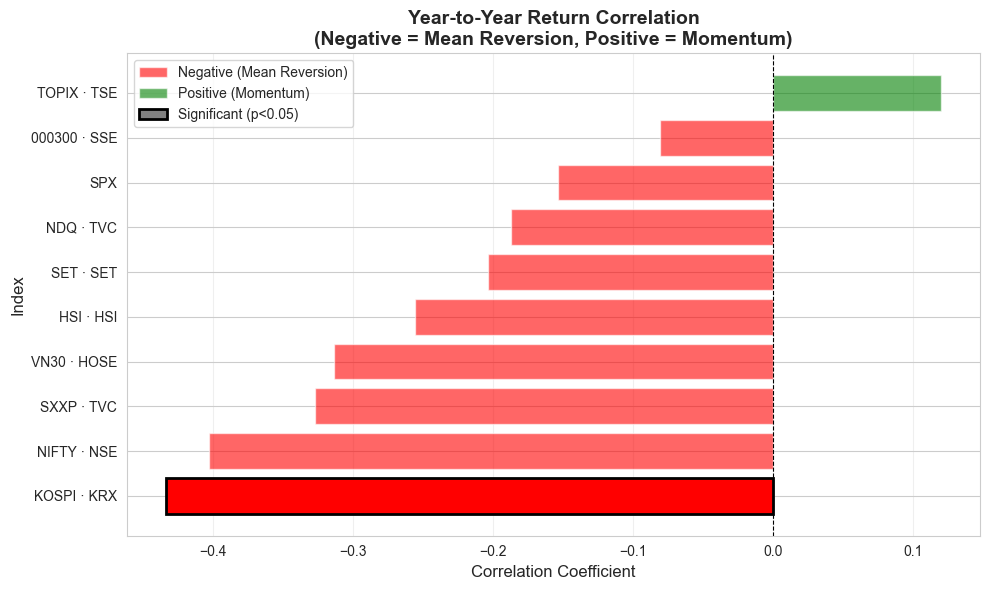

In [21]:
# Plot correlation coefficients
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if c < 0 else 'green' for c in results_df['Correlation']]
bars = ax.barh(results_df['Index'], results_df['Correlation'], color=colors, alpha=0.6)

# Highlight significant results
for i, (idx, row) in enumerate(results_df.iterrows()):
    if row['Significant (p<0.05)']:
        bars[i].set_alpha(1.0)
        bars[i].set_edgecolor('black')
        bars[i].set_linewidth(2)

ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
ax.set_ylabel('Index', fontsize=12)
ax.set_title('Year-to-Year Return Correlation\n(Negative = Mean Reversion, Positive = Momentum)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.6, label='Negative (Mean Reversion)'),
    Patch(facecolor='green', alpha=0.6, label='Positive (Momentum)'),
    Patch(facecolor='gray', alpha=1.0, edgecolor='black', linewidth=2, label='Significant (p<0.05)')
]
ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

## 5. Cross-Sectional Analysis: Ranking-Based Test

In [22]:
# Alternative test: Rank indexes by performance each year,
# then see if top performers tend to become bottom performers

# Calculate ranks for each year (1 = best performer, higher = worse)
yearly_ranks = yearly_returns.rank(axis=1, ascending=False)

# For each year, get the previous year's rank
prev_year_ranks = yearly_ranks.shift(1)

# Flatten the data for correlation analysis
current_ranks = []
previous_ranks = []

for year in yearly_ranks.index:
    if year == yearly_ranks.index[0]:
        continue
    
    for col in yearly_ranks.columns:
        curr = yearly_ranks.loc[year, col]
        prev = prev_year_ranks.loc[year, col]
        
        if pd.notna(curr) and pd.notna(prev):
            current_ranks.append(curr)
            previous_ranks.append(prev)

# Calculate correlation
if len(current_ranks) > 0:
    rank_corr, rank_p = stats.pearsonr(previous_ranks, current_ranks)
    
    print("\n" + "="*80)
    print("CROSS-SECTIONAL RANK CORRELATION")
    print("="*80)
    print(f"Correlation between previous year rank and current year rank: {rank_corr:.4f}")
    print(f"P-value: {rank_p:.6f}")
    print(f"Sample size: {len(current_ranks)} index-year pairs")
    print("\nInterpretation:")
    if rank_corr > 0:
        print("  Positive correlation = Winners tend to stay winners (MOMENTUM)")
    else:
        print("  Negative correlation = Winners tend to become losers (MEAN REVERSION)")
    
    if rank_p < 0.05:
        print(f"  Result is statistically significant (p={rank_p:.6f} < 0.05)")
    else:
        print(f"  Result is NOT statistically significant (p={rank_p:.6f} >= 0.05)")


CROSS-SECTIONAL RANK CORRELATION
Correlation between previous year rank and current year rank: 0.0751
P-value: 0.264959
Sample size: 222 index-year pairs

Interpretation:
  Positive correlation = Winners tend to stay winners (MOMENTUM)
  Result is NOT statistically significant (p=0.264959 >= 0.05)


## 5b. Spearman Rank Correlation Analysis

In [23]:
# Spearman rank correlation: Rank indexes cross-sectionally each year,
# then calculate correlation between ranks in consecutive years

# For each year, rank all indexes based on their returns
# Rank 1 = best performer, higher rank = worse performer
yearly_ranks_spearman = yearly_returns.rank(axis=1, ascending=False)

print("Yearly ranks (1=Best performer each year):")
print(yearly_ranks_spearman.head(10))

# Calculate Spearman correlation for each year transition
yearly_spearman_corr = []
yearly_spearman_p = []
year_pairs = []

for i in range(1, len(yearly_ranks_spearman)):
    prev_year_idx = yearly_ranks_spearman.index[i-1]
    curr_year_idx = yearly_ranks_spearman.index[i]
    
    prev_ranks = yearly_ranks_spearman.iloc[i-1].dropna()
    curr_ranks = yearly_ranks_spearman.iloc[i].dropna()
    
    # Get common indexes (those that have data in both years)
    common_indexes = prev_ranks.index.intersection(curr_ranks.index)
    
    if len(common_indexes) >= 3:  # Need at least 3 indexes for meaningful correlation
        prev_vals = prev_ranks[common_indexes]
        curr_vals = curr_ranks[common_indexes]
        
        # Calculate Spearman correlation
        corr, p_val = stats.spearmanr(prev_vals, curr_vals)
        
        yearly_spearman_corr.append(corr)
        yearly_spearman_p.append(p_val)
        year_pairs.append(f"{prev_year_idx}-{curr_year_idx}")

# Create DataFrame of year-by-year results
spearman_df = pd.DataFrame({
    'Year_Transition': year_pairs,
    'Spearman_Corr': yearly_spearman_corr,
    'P_Value': yearly_spearman_p,
    'Significant': [p < 0.05 for p in yearly_spearman_p]
})

print("\n" + "="*80)
print("YEAR-BY-YEAR SPEARMAN RANK CORRELATION")
print("="*80)
print("(Correlation between rank in year T and rank in year T+1)")
print(spearman_df.to_string(index=False))

# Overall statistics
avg_spearman = np.mean(yearly_spearman_corr)
median_spearman = np.median(yearly_spearman_corr)
negative_count = sum(1 for c in yearly_spearman_corr if c < 0)
positive_count = sum(1 for c in yearly_spearman_corr if c > 0)
sig_negative_count = sum(1 for c, p in zip(yearly_spearman_corr, yearly_spearman_p) if c < 0 and p < 0.05)
sig_positive_count = sum(1 for c, p in zip(yearly_spearman_corr, yearly_spearman_p) if c > 0 and p < 0.05)

print("\n" + "="*80)
print("SPEARMAN CORRELATION SUMMARY")
print("="*80)
print(f"Average Spearman correlation: {avg_spearman:.4f}")
print(f"Median Spearman correlation: {median_spearman:.4f}")
print(f"\nNegative correlations: {negative_count} / {len(yearly_spearman_corr)} year transitions")
print(f"Positive correlations: {positive_count} / {len(yearly_spearman_corr)} year transitions")
print(f"\nStatistically significant (p<0.05):")
print(f"  - Significantly negative: {sig_negative_count}")
print(f"  - Significantly positive: {sig_positive_count}")
print(f"\nInterpretation:")
if avg_spearman < 0:
    print(f"  Negative average = MEAN REVERSION (last year's winners become losers)")
else:
    print(f"  Positive average = MOMENTUM (last year's winners keep winning)")

Yearly ranks (1=Best performer each year):
      SPX  SET · SET  VN30 · HOSE  NIFTY · NSE  HSI · HSI  000300 · SSE  \
year                                                                      
2000  NaN        NaN          NaN          NaN        NaN           NaN   
2001  3.0        2.0          NaN          4.0        6.0           NaN   
2002  6.0        1.0          NaN          2.0        4.0           NaN   
2003  6.0        1.0          NaN          2.0        4.0           NaN   
2004  7.0        8.0          NaN          2.0        1.0           NaN   
2005  7.0        5.0          NaN          3.0        6.0           NaN   
2006  5.0        9.0          NaN          2.0        3.0           1.0   
2007  7.0        5.0          NaN          2.0        3.0           1.0   
2008  1.0        6.0          NaN          8.0        7.0           9.0   
2009  8.0        3.0          NaN          2.0        5.0           1.0   

      KOSPI · KRX  TOPIX · TSE  SXXP · TVC  NDQ · TVC  


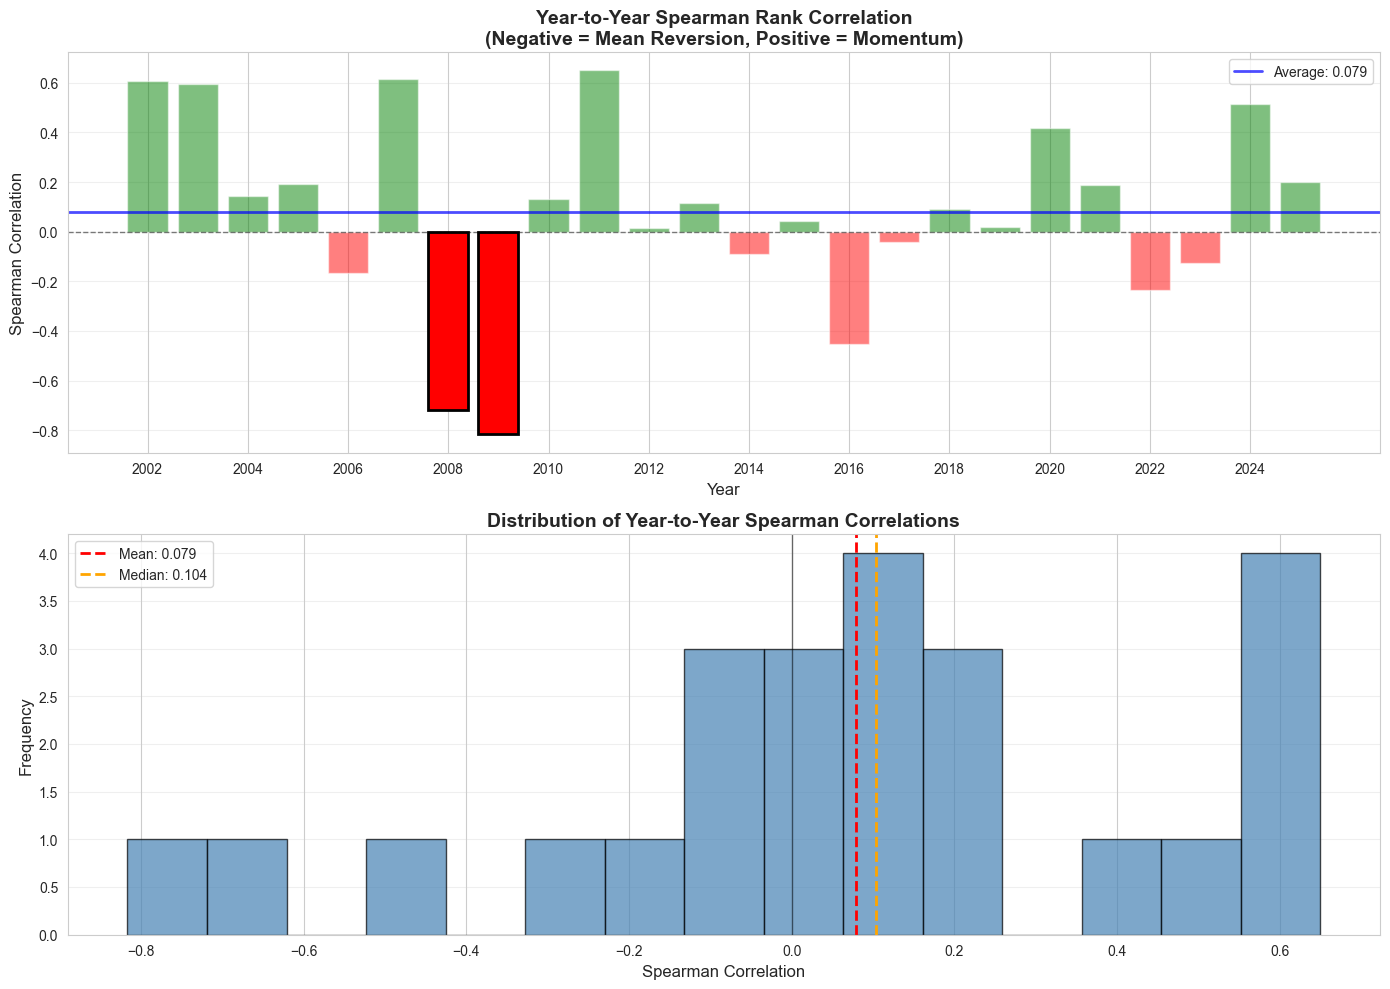


STATISTICAL TEST: Is average Spearman correlation different from zero?
T-statistic: 0.9908
P-value: 0.332101
Result: Average correlation is NOT significantly different from zero


In [24]:
# Visualize Spearman correlations over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Time series of Spearman correlations
years = [int(yp.split('-')[1]) for yp in year_pairs]
colors = ['red' if c < 0 else 'green' for c in yearly_spearman_corr]
alphas = [1.0 if sig else 0.5 for sig in spearman_df['Significant']]

bars = ax1.bar(years, yearly_spearman_corr, color=colors, alpha=0.7)
for i, (bar, alpha) in enumerate(zip(bars, alphas)):
    bar.set_alpha(alpha)
    if spearman_df['Significant'].iloc[i]:
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

ax1.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax1.axhline(avg_spearman, color='blue', linewidth=2, linestyle='-', 
            label=f'Average: {avg_spearman:.3f}', alpha=0.7)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Spearman Correlation', fontsize=12)
ax1.set_title('Year-to-Year Spearman Rank Correlation\n(Negative = Mean Reversion, Positive = Momentum)', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()
ax1.set_xticks(years[::2])  # Show every other year to avoid crowding

# Plot 2: Distribution of Spearman correlations
ax2.hist(yearly_spearman_corr, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(avg_spearman, color='red', linewidth=2, linestyle='--', 
            label=f'Mean: {avg_spearman:.3f}')
ax2.axvline(median_spearman, color='orange', linewidth=2, linestyle='--', 
            label=f'Median: {median_spearman:.3f}')
ax2.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax2.set_xlabel('Spearman Correlation', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Year-to-Year Spearman Correlations', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test: Is the average Spearman correlation significantly different from zero?
t_stat, t_pval = stats.ttest_1samp(yearly_spearman_corr, 0)
print("\n" + "="*80)
print("STATISTICAL TEST: Is average Spearman correlation different from zero?")
print("="*80)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_pval:.6f}")
if t_pval < 0.05:
    if avg_spearman < 0:
        print(f"Result: Average correlation is SIGNIFICANTLY NEGATIVE (mean reversion)")
    else:
        print(f"Result: Average correlation is SIGNIFICANTLY POSITIVE (momentum)")
else:
    print(f"Result: Average correlation is NOT significantly different from zero")
print("="*80)

## 6. Quintile Analysis: Top vs Bottom Performers

In [25]:
# Group indexes by performance quintiles and track their next-year performance

quintile_data = []

for year in yearly_returns.index[:-1]:  # Exclude last year (no next year data)
    next_year = year + 1
    
    if next_year not in yearly_returns.index:
        continue
    
    # Get current year returns
    current = yearly_returns.loc[year].dropna()
    
    if len(current) < 5:  # Need at least 5 indexes for quintiles
        continue
    
    # Create quintiles based on current year performance
    current_sorted = current.sort_values(ascending=False)
    n_per_quintile = len(current_sorted) // 5
    
    for q in range(5):
        start_idx = q * n_per_quintile
        end_idx = (q + 1) * n_per_quintile if q < 4 else len(current_sorted)
        
        quintile_indexes = current_sorted.index[start_idx:end_idx]
        
        # Get next year returns for these indexes
        next_year_returns = yearly_returns.loc[next_year, quintile_indexes].dropna()
        
        if len(next_year_returns) > 0:
            quintile_data.append({
                'Year': year,
                'Quintile': q + 1,
                'Quintile_Label': f'Q{q+1} ({"Top" if q == 0 else "Bottom" if q == 4 else "Mid"})',
                'Current_Avg_Return': current_sorted.iloc[start_idx:end_idx].mean(),
                'Next_Year_Avg_Return': next_year_returns.mean(),
                'N_Indexes': len(next_year_returns)
            })

quintile_df = pd.DataFrame(quintile_data)

# Summary by quintile
quintile_summary = quintile_df.groupby('Quintile_Label').agg({
    'Current_Avg_Return': 'mean',
    'Next_Year_Avg_Return': 'mean',
    'N_Indexes': 'sum'
}).round(2)

print("\n" + "="*80)
print("QUINTILE ANALYSIS: CURRENT YEAR PERFORMANCE -> NEXT YEAR PERFORMANCE")
print("="*80)
print(quintile_summary)
print("\nIf hypothesis is true: Top quintile (Q1) should have lower next-year returns")


QUINTILE ANALYSIS: CURRENT YEAR PERFORMANCE -> NEXT YEAR PERFORMANCE
                Current_Avg_Return  Next_Year_Avg_Return  N_Indexes
Quintile_Label                                                     
Q1 (Top)                     41.20                 13.51         36
Q2 (Mid)                     20.93                 14.66         36
Q3 (Mid)                     12.74                 11.99         36
Q4 (Mid)                      5.44                  7.92         36
Q5 (Bottom)                  -5.84                 10.63         78

If hypothesis is true: Top quintile (Q1) should have lower next-year returns


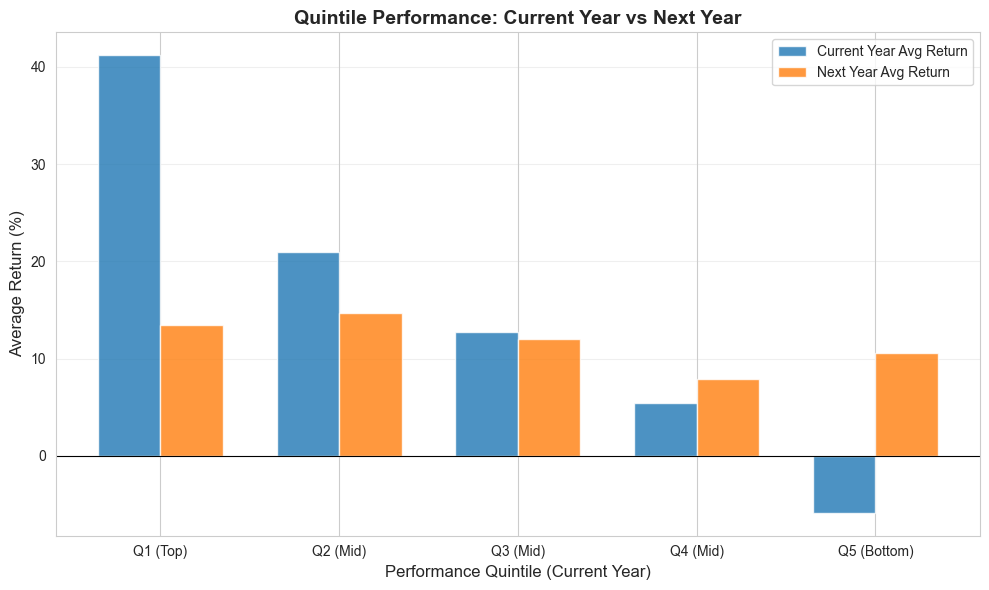

In [26]:
# Visualize quintile performance
fig, ax = plt.subplots(figsize=(10, 6))

quintile_order = ['Q1 (Top)', 'Q2 (Mid)', 'Q3 (Mid)', 'Q4 (Mid)', 'Q5 (Bottom)']
quintile_summary_sorted = quintile_summary.reindex([q for q in quintile_order if q in quintile_summary.index])

x = np.arange(len(quintile_summary_sorted))
width = 0.35

bars1 = ax.bar(x - width/2, quintile_summary_sorted['Current_Avg_Return'], 
               width, label='Current Year Avg Return', alpha=0.8)
bars2 = ax.bar(x + width/2, quintile_summary_sorted['Next_Year_Avg_Return'], 
               width, label='Next Year Avg Return', alpha=0.8)

ax.set_xlabel('Performance Quintile (Current Year)', fontsize=12)
ax.set_ylabel('Average Return (%)', fontsize=12)
ax.set_title('Quintile Performance: Current Year vs Next Year', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(quintile_summary_sorted.index, rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(0, color='black', linewidth=0.8, linestyle='-')

plt.tight_layout()
plt.show()

## 7. Conclusion

In [27]:
print("\n" + "="*80)
print("HYPOTHESIS TEST CONCLUSION")
print("="*80)
print("\nHypothesis: 'If an index was the best performer last year, it tends to underperform this year'")
print("\nEvidence:")
print(f"  1. Individual index correlations (Pearson):")
print(f"     - Average correlation: {results_df['Correlation'].mean():.4f}")
print(f"     - Negative correlations: {(results_df['Correlation'] < 0).sum()} / {len(results_df)} indexes")
print(f"     - Significantly negative: {len(sig_negative)} indexes")
print(f"\n  2. Cross-sectional rank analysis (Pearson on ranks):")
print(f"     - Rank correlation: {rank_corr:.4f} (p={rank_p:.6f})")
print(f"\n  3. Spearman rank correlation (year-to-year):")
print(f"     - Average Spearman correlation: {avg_spearman:.4f}")
print(f"     - Negative year transitions: {negative_count} / {len(yearly_spearman_corr)}")
print(f"     - T-test p-value: {t_pval:.6f} {'(SIGNIFICANT)' if t_pval < 0.05 else '(not significant)'}")
print(f"\n  4. Quintile analysis:")
top_next = quintile_summary.loc['Q1 (Top)', 'Next_Year_Avg_Return'] if 'Q1 (Top)' in quintile_summary.index else None
bottom_next = quintile_summary.loc['Q5 (Bottom)', 'Next_Year_Avg_Return'] if 'Q5 (Bottom)' in quintile_summary.index else None
if top_next is not None and bottom_next is not None:
    print(f"     - Top quintile next year return: {top_next:.2f}%")
    print(f"     - Bottom quintile next year return: {bottom_next:.2f}%")
    print(f"     - Difference: {top_next - bottom_next:.2f}% (negative = mean reversion)")

print("\n" + "="*80)
# Updated verdict logic to include Spearman results
individual_negative = results_df['Correlation'].mean() < 0
spearman_negative = avg_spearman < 0
spearman_significant = t_pval < 0.05

if individual_negative and spearman_negative:
    if spearman_significant:
        print("VERDICT: STRONG EVIDENCE FOR MEAN REVERSION HYPOTHESIS")
        print("  - Both individual and cross-sectional analyses show negative correlations")
        print("  - Spearman correlation is statistically significant")
    else:
        print("VERDICT: MODERATE EVIDENCE FOR MEAN REVERSION HYPOTHESIS")
        print("  - Both individual and cross-sectional analyses show negative correlations")
        print("  - However, not statistically significant at p<0.05 level")
elif not individual_negative and not spearman_negative:
    print("VERDICT: DATA SHOWS MOMENTUM (CONTRADICTS HYPOTHESIS)")
else:
    print("VERDICT: MIXED EVIDENCE - NO CLEAR PATTERN")
    print("  - Different methodologies yield conflicting results")
print("="*80)


HYPOTHESIS TEST CONCLUSION

Hypothesis: 'If an index was the best performer last year, it tends to underperform this year'

Evidence:
  1. Individual index correlations (Pearson):
     - Average correlation: -0.2236
     - Negative correlations: 9 / 10 indexes
     - Significantly negative: 1 indexes

  2. Cross-sectional rank analysis (Pearson on ranks):
     - Rank correlation: 0.0751 (p=0.264959)

  3. Spearman rank correlation (year-to-year):
     - Average Spearman correlation: 0.0788
     - Negative year transitions: 8 / 24
     - T-test p-value: 0.332101 (not significant)

  4. Quintile analysis:
     - Top quintile next year return: 13.51%
     - Bottom quintile next year return: 10.63%
     - Difference: 2.88% (negative = mean reversion)

VERDICT: MIXED EVIDENCE - NO CLEAR PATTERN
  - Different methodologies yield conflicting results
